# Week 3 - Density Based Clustering

During this weeks exercises, we will be working with density based clustering.
In particular, we will be working with the algorithms DBSCAN, DENCLUE, Incremental DBSCAN, and AnyDBC.

First, lets import some stuff and plot the data that we are going to use today.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Local imports
import sys
sys.path.append('..')
from utilities.load_data import load_iris_PC, load_t7

## Exercise 1: Theoretical questions
- Please provide a brief description of what characterises density-based clustering as a clustering approach? How do both DBSCAN and DENCLUE define clusters, and what is the core difference between the two? 

## Exercise 2: DBSCAN in Action
Consider Figure 15.12 and answer the following questions, assuming that we use the
Euclidean distance between points, and that $\epsilon=2$ and $minpts = 3$
1. List all the core points.
1. Is $a$ directly density reachable from $d$?
1. Is $o$ density reachable from $i$? Show the intermediate points on the chain or the point where the chain breaks.
1. Is density reachable a symmetric relationship, that is, if $x$ is density reachable from $y$, does it imply that $y$ is density reachable from $x$? Why or why not?
1. Is $l$ density connected to $x$? Show the intermediate points that make them density connected or violate the property, respectively.
1. Is density connected a symmetric relationship?
1. Show the density-based clusters and the noise points.
1. If we use the manhattan distance instead, what is then the core points?

<img src="graphics/15.12.png" width="501" />

We have included the points in the code below, if you want to use `numpy`.

In [2]:
X = np.array([
    [5., 10., 11., 6., 10., 12., 13., 5., 10., 13., 6., 9., 11., 14., 15., 2., 3., 5., 6., 7., 15., 3., 7., 8.],
    [8.,  8.,  8., 7.,  7.,  7.,  7., 6.,  6.,  6., 5., 4.,  5.,  6.,  5., 4., 4., 4., 4., 4.,  4., 3., 3., 2.]
]).T
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x']

core_points = []
for i,c in enumerate(labels):
    neighbours = 0
    p1 = X[i]
    for j,_ in enumerate(labels):
        p2 = X[j]
        dist = np.linalg.norm(p1-p2)
        if dist <= 2:
           neighbours += 1
    if neighbours >= 3:
        core_points.append(c)
labels.sort()
print(core_points)


['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'n', 'o', 'p', 'q', 'r', 's', 't', 'v', 'w']


## Exercise 3: Implement DBSCAN

In this exercise, we will try to implement the DBSCAN algorithm. 
You are allowed to structure your code however you want. 
The code below is inspired by [Zaki, p. 377] and serves as inspiration.

In [18]:
def L2_norm(x, y):
    return np.sqrt(np.sum((x-y)**2))

def densityConnected(i, neighborhood, visited, cluster): # You might need more parameters here.
    if not visited[i]:
        visited[i] = True
        cluster.append(i)
        for j in neighborhood[i]:
            # Connect (potentially recursively)
            cluster = densityConnected(j, neighborhood, visited, cluster)
            pass
    return cluster
def dbscan(X, e, m, dist_fn=L2_norm):
    """
        Args:
            X:       Matrix of shape [n, d] with data points on the rows.
            e:       Epsilon distance for neighborhood calculations.
            m:       Minimum neighbors in epsilon neighborhood for a point to be a core point.
            dist_fn: Distance function to be used.
        
        Returns:
            clusters:   A vector of shape [n,] with integers, indicating cluster assignments.
                        Let clusters[i] == -1 if point x_i is an outlier and a non-negative 
                        integer corresponding to the cluster index of point x_i otherwise.
    """
    
    # TODO, code here.
    
    core = []
    neighborhood = dict()
    for i,x in enumerate(X):
        # Compute neighborhoods and identify cores
        pts = 0
        my_neighbors = []
        for j,y in enumerate(X):
            dist = dist_fn(x, y)
            if dist <= e:
                pts += 1
                my_neighbors.append(j)
        neighborhood[i] = my_neighbors
        if pts >= m:
            core.append(i)
        pass

    clusters = np.full(len(X), -1)
    visited = np.full(len(X), False)
    k = 0
    for c in core:
        # Assign unassigned cores to clusters
        # using densityConnect
        cluster = densityConnected(i, neighborhood, visited, [])
        for i in cluster:
            clusters[i] = k
        k += 1
        pass

    # End TODO
    
    return clusters

Here is some code to try out your implementation.
You can, of course, fiddle with the parameters and see what happens to the clusters.
The parameters provided below whould work relatively well.

/home/quack/Projects/datamining/dm2021-exercises/utilities/data/iris-PC.txt


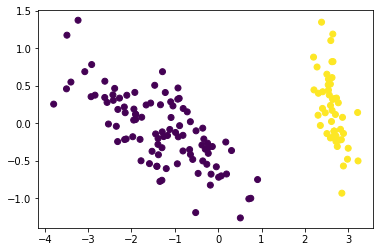

In [19]:
# Test clustering on iris_PC dataset
# clustering = dbscan(X, 0.5, 5) # Works for iris_2PC dataset
slow = False
if slow:
    X, _ = load_t7()
    clustering = dbscan(X, e=15, m=10)
else: 
    X, _ = load_iris_PC()
    clustering = dbscan(X, e=0.4, m=5)

fig, ax = plt.subplots(1, 1)
ax.scatter(*(X.T), c=clustering)
plt.show()

## Exercise 4: DENCLUE Calculations
This exercise relates to the DENCLUE algorithm introduced in Section 15.3 in [Zaki].
Consider the points shown in Figure 15.13. For the Gaussian kernel

$$
K(\mathbf{z})=\frac{1}{(2 \pi)^{d / 2}} \exp \left\{-\frac{\mathbf{z}^{T} \mathbf{z}}{2}\right\},
$$

<img src="graphics/15.13.png" width="400" />

answer the following questions assuming that $h = 2$:

1. What is the probability density at e?
2. What is the gradient at e? (Try to actually derive the gradient of $\hat f(x)$ your self)
3. List all the density attractors for this dataset.

As before, if you want to use `numpy`, we have included the points below.

In [ ]:
X = np.array([
    [5., 6., 6., 2., 3., 5., 7., 9., 3., 8., 7.],
    [8., 7., 5., 4., 4., 4., 4., 4., 3., 2., 5.]
]).T
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k']

## Exercise 5: Incremental DBSCAN

Consider the points from Exercise 2 with the two clustes that we found in the end.
In an online setting, use the Incremental DBSCAN algorithm to do the following updates.

<img src="graphics/15.12.png" width="500" />

1. Delete $n$ 
1. Delete $v$
1. Delete $s$
1. Add point $y=(9,5)$ 
1. Assume you are given a DBSCAN clustering on 500 points. You now receive a batch of 10 points. If you would like to make best use of an incremental approach, how would you proceed? 

# Optionals

## Exercise 6: AnyDBC
Again, consider Figure 15.12 and answer the following questions

1. What are the minimal number of queries needed to recover the DBSCAN clusters?
2. How would the connection graph look like given these queries?
3. Describe how the score function used to select the next range query is works.
4. Consider a scoring function in AnyDBC which assigns high scores to points for which a large number of neighbours is known. What is the impact on the clustering performance? 

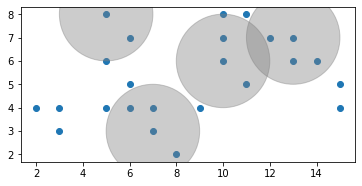

In [10]:
X = np.array([
    [5., 10., 11., 6., 10., 12., 13., 5., 10., 13., 6., 9., 11., 14., 15., 2., 3., 5., 6., 7., 15., 3., 7., 8.],
    [8.,  8.,  8., 7.,  7.,  7.,  7., 6.,  6.,  6., 5., 4.,  5.,  6.,  5., 4., 4., 4., 4., 4.,  4., 3., 3., 2.]
]).T
        #    0    1    2     3   4    5    6    7    8    9   10   11   12   13   14    15  16    17  18   19   20   21   22    23
# labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x']

fig, ax = plt.subplots(1,1)
ax.scatter(*(X.T))
plt.gca().set_aspect('equal', adjustable='box')

def plt_radius(point, e):
    c = plt.Circle(point, e, color='grey', alpha=0.4)
    ax.add_artist(c)

epsilon = 2.
points = [0, 6, 8, 22]
for i in points:
    plt_radius(X[i], epsilon)


## Exercise 7: DBSCAN with Gaussian kernel

In this exercise, we are going to alter the DBSCAN algorithm to use another kernel.

As stated in [Zaki, p.388], DBSCAN is a special case of DENCLUE.
In particular, if we let $h=\epsilon$ and $\xi = minPts$ with a discrete kernel, then the two algorithms will yield the same result.

We are now going to go a step in the other direction.
Thas is, we will add a Gaussian kernel to the DBSCAN algorithm.
The Gaussian kernel is defined as in Equation (1).

$$
K(\mathbf{z})=\frac{1}{(2 \pi)^{d / 2}} \exp \left\{-\frac{\mathbf{z}^{T} \mathbf{z}}{2}\right\}
\qquad \qquad (1)
$$

The implications in terms of the algorithm are the following:

1. When selecting core points, they are now going to depend on a threshold $\xi$ of the density estimates $\hat f(x)$.
2. The threshold $\epsilon$ is now going to be compared against $K(\frac{x-x_i}{h})$ when calculating neighborhoods and density connectedness.
3. The value $h$ which was previously fixed to $\epsilon$ is now going to be a parameter to the model.

As before, the code below serves as inspiration.

In [ ]:
def K(z):
    return  np.exp(-np.dot(z, z)/2) / np.sqrt(2*np.pi)

def densityConnected(x, k, ...): # You might need more parameters here.
    for neighbor in x.Nx:
        # Connect (potentially recursively)
        pass

def gaussian_dbscan(X, e, xi, h):
    """
        Args:
            X:       Matrix of shape [n, d] with data points on the rows.
            e:       Epsilon distance for neighborhood calculations.
            m:       Minimum neighbors in epsilon neighborhood for a point to be a core point.
            dist_fn: Distance function to be used.
        
        Returns:
            clusters:   A vector of shape [n,] with integers, indicating cluster assignments.
                        Let clusters[i] == -1 if point x_i is an outlier and a non-negative 
                        integer corresponding to the cluster index of point x_i otherwise.
    """
    
    # TODO, code here.
    
    core = []
    for x in X:
        # Compute neighborhoods and identify cores
        pass

    k = 0
    for c in core:
        # Assign unassigned cores to clusters
        # using densityConnect
        pass

    clusters = []
    for i in range(k):
        # Build cluster indicator vector
        pass
    
    # End TODO
    
    return clusters


You can use the code below to run your algorithm.

In [ ]:
# Test clustering on iris_PC dataset
np.random.seed(0)

slow = True
if slow:
    X, _ = load_t7()
    n, _ = X.shape
    X = X[np.random.permutation(n)]
    X = X[:2000]
    clustering = gaussian_dbscan(X, e=0.0001, xi=0.4, h=3.25)
else: 
    X, _ = load_iris_PC()
    clustering = gaussian_dbscan(X, e=0.2, xi=12., h=0.7)

fig, ax = plt.subplots(1, 1)
sc = ax.scatter(*(X[clustering >= 0].T), c=clustering[clustering>=0])
sc = ax.scatter(*(X[clustering < 0].T), marker='x')
plt.colorbar(sc)
plt.show()

# Exercise 8: Comparing the DBSCAN versions above
Please describe how the two versions of DBSCAN above differ.
How do you think the the differences affects the clustering of the data?

Did you see any practical differences in the "experiments" above?